# HW 11, Assignment 1
## More work with GeoPandas
### Author: Sofiya Elyukin

In [1]:
from __future__ import print_function
import os
import geopandas as gp
from fiona.crs import from_epsg
import shapely
import pylab as pl
import matplotlib.patches as mpatches
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Get data
# Code outputs "256", but there doesn't seem to be any issue
os.system("curl -O http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip")
os.system("unzip /nycb2010_16d.zip")
os.system("mv nycb2010_16d " + os.getenv("PUIDATA"))

256

In [3]:
# Load census tracts using geopandas, and convert coordinates to lat/lon
shape_path = os.getenv("PUIDATA") + "/nycb2010_16d/nycb2010.shp"
ct_shape = gp.GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BCTCB2010

In [4]:
ct_shape.crs = from_epsg(2263) # epsg=4326: lat/on | epsg=2263 is US feet
ct_latlon=ct_shape.to_crs(epsg=4326)

In [5]:
ct_latlon.head(5)

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
BCTCB2010,,,,,,,,
50009001000,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,POLYGON ((-74.07920577013245 40.64343078374566...
50020011000,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,POLYGON ((-74.07061992438018 40.61085506705415...
50027001000,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,POLYGON ((-74.07524403910642 40.62600632452711...
50040001000,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,POLYGON ((-74.08708799689826 40.61116883123923...
50064001000,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,POLYGON ((-74.07643744511992 40.60100160655585...


In [6]:
# Extract Brooklyn tracts
bk_ct = ct_latlon[(ct_latlon["BoroCode"] == '3')]
print ('There are %s Census Tracts in Brooklyn' %len(bk_ct))
bk_ct.head(5)

There are 9682 Census Tracts in Brooklyn


,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
BCTCB2010,,,,,,,,
30002001000,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,POLYGON ((-74.00659158337982 40.65561273365177...
30003011000,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384567195...
30005011000,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,POLYGON ((-73.99270830309769 40.69809925981344...
30011001000,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,POLYGON ((-73.98514306089652 40.69488514296981...
30015001000,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,POLYGON ((-73.98305147125492 40.69837793354038...


In [7]:
# Found coordinates of CUSP on Google Maps, created a Point geometry
cusp = shapely.geometry.Point(-73.986612, 40.693043)
print (type(cusp))
#cusp?

<class 'shapely.geometry.point.Point'>


In [8]:
# figured out loop and conditional using code within hw instructions and code from Scott Smith (ss4977)

for i in bk_ct.index:
    if shapely.geometry.asShape(bk_ct.geometry.loc[i]).contains(cusp):
        cusp_ct = bk_ct.BCTCB2010[i]
        print ('CUSP is contained in Census Tract %s:, ' %cusp_ct, bk_ct.geometry[i])

CUSP is contained in Census Tract 30011001008:,  POLYGON ((-73.98622595691907 40.69308831340506, -73.98627231669104 40.69219479463375, -73.98729894947923 40.69223407539822, -73.98725396415627 40.6931249027317, -73.98622595691907 40.69308831340506))


In [9]:
# Reduce to only every ten Brooklyn tracts
bk_ct_reduced = bk_ct[::10]
len(bk_ct_reduced)

969

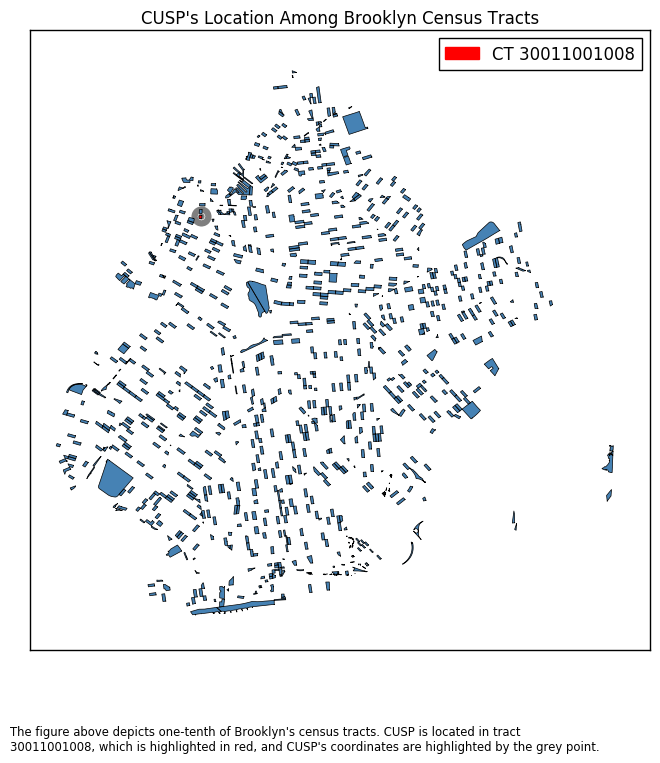

In [10]:
# Plot the reduced set of tracts, CUSP's tract, and CUSP's coordinate
f, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(-74.05, -73.82)
ax.set_ylim(40.56, 40.75)
bk_ct_reduced.plot(alpha=1, linewidth=0.5, ax=ax, color='SteelBlue')
bk_ct[(bk_ct.index == cusp_ct)].plot(alpha=1, linewidth=0.5, ax=ax, color='red')
pl.scatter(cusp.x, cusp.y, alpha=0.5, color='black', linewidths=10)
ax.set_title("CUSP's Location Among Brooklyn Census Tracts", fontsize='large')
pl.figtext(0.1, -0.00000000001, '''The figure above depicts one-tenth of Brooklyn's census tracts. CUSP is located in tract
%s, which is highlighted in red, and CUSP's coordinates are highlighted by the grey point.''' %cusp_ct, 
           fontsize='small')
red_patch = mpatches.Patch(color='red', label='CT %s' %cusp_ct)
plt.legend(handles=[red_patch])